#LSTM & BiLSTM

In this colab we have tried to use the Long Short Term Memory and the Bidirectional LSTM.

##Importing libraries and dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
import warnings
import logging
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import sklearn.preprocessing as prep

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [20]:
!unzip -q /gdrive/MyDrive/ANNDL/Homework2/training_dataset_homework2.zip

replace y_train.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


##Data preprocessing

(2429,)


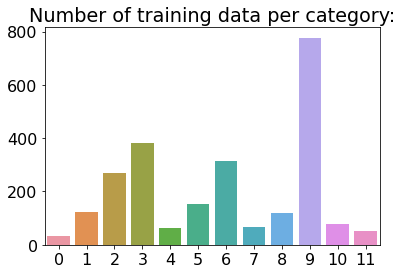

In [21]:
# Data load

x_data = np.load('x_train.npy')
y_data = np.load('y_train.npy')

print(y_data.shape)


classes = np.zeros(12)
for x in y_data:
  classes[x] +=1

sns.barplot(x=np.arange(12), y=classes).set_title("Number of training data per category:")
weight = max(classes)/classes
class_weight = {}
for i in range(12):
  class_weight[i] = weight[i]

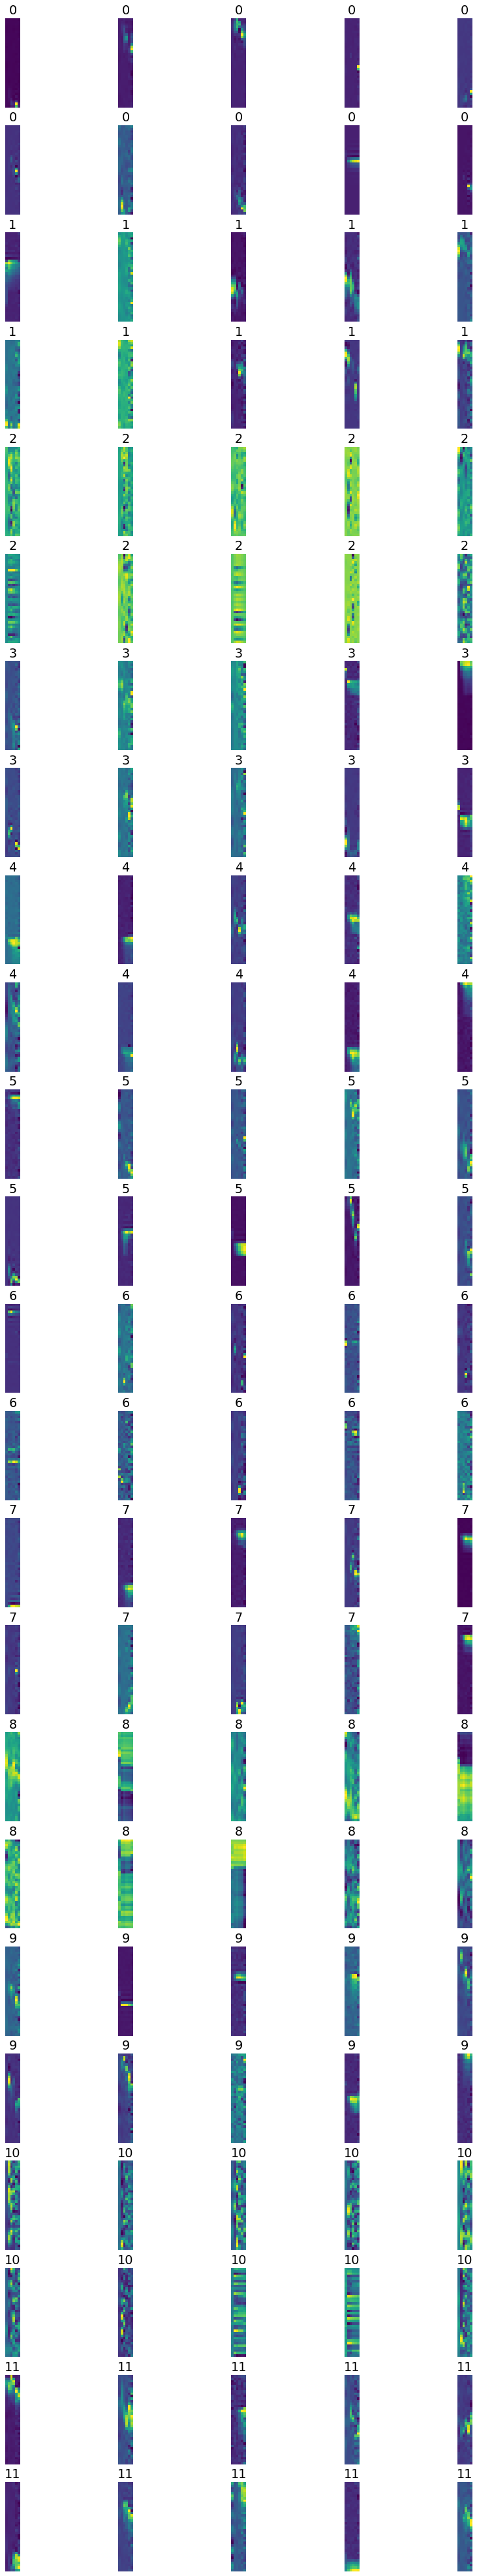

In [22]:
# Inspect the data

num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row*12, num_col, figsize=(3*num_col,3*num_row*12))

counter = 0
for c in range(12):
  start_index = np.where(y_data == c)[0][0]
  
  for i in range(num_row*num_col):
    ax = axes[counter//num_col, counter%num_col]
    ax.imshow(x_data[i + start_index])
    ax.set_title(y_data[i + start_index])
    ax.axis('off')
    counter = counter + 1

plt.show()

In [23]:
# Preprocess the data

window = 108

X_data = x_data
y_data_tmp = y_data


# Scale with respect to the window

scaler = RobustScaler()
for i in range(len(X_data)):
  tmp = np.reshape(X_data[i],(X_data.shape[1]*X_data.shape[2],1))
  scaler = scaler.fit(tmp)
  tmp = scaler.transform(tmp)
  X_data[i] = np.reshape(tmp, (36,6))

X_data = np.reshape(X_data,(X_data.shape[0],X_data.shape[1],X_data.shape[2]))

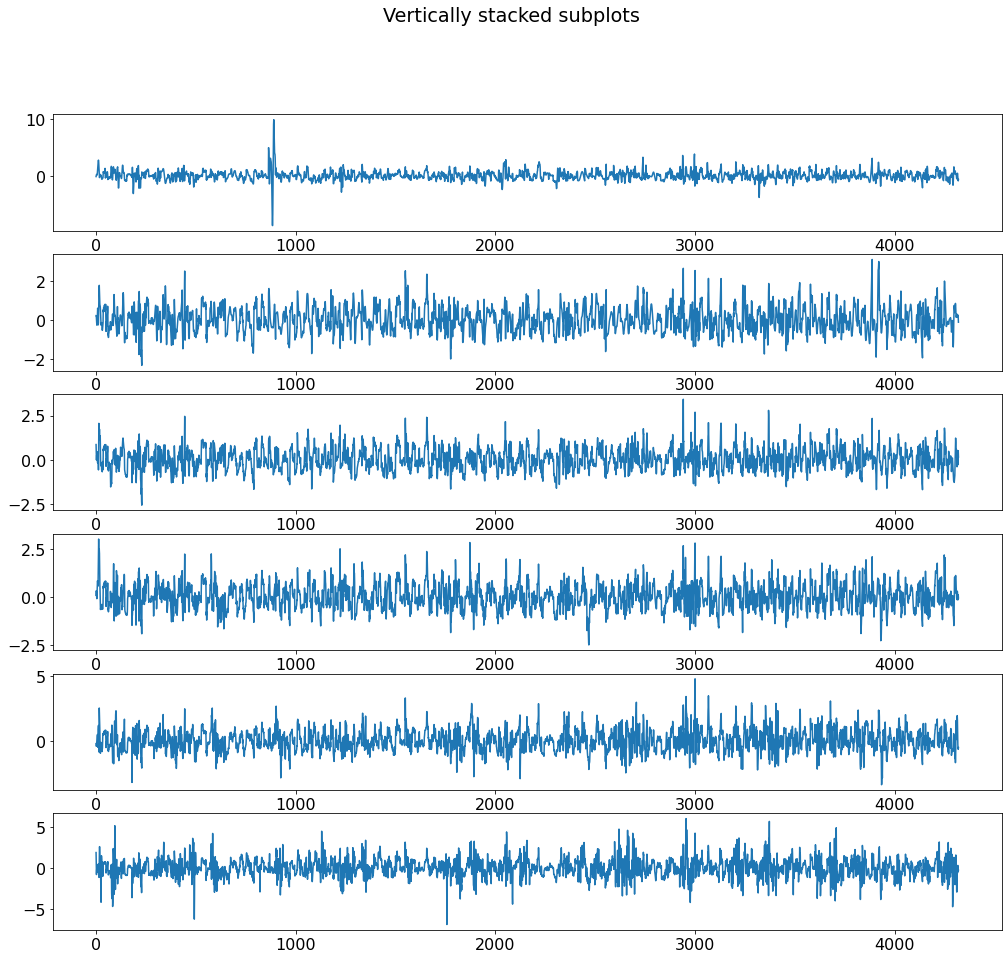

In [15]:
fig, ax = plt.subplots(6, figsize=(17, 15))
fig.suptitle('Vertically stacked subplots')

for i in range(6):
  arr = []
  for x in range(len(y_data)):
    if y_data[x] == 8:
      arr = np.append(arr,(X_data[x,:,i]))
  ax[i].plot(arr)

Splitting dataset into train and validation set

In [28]:
Y_data = tfk.utils.to_categorical(y_data_tmp)

x_train, x_val, y_train, y_val = train_test_split(X_data, Y_data, test_size=0.2, shuffle= True, stratify=Y_data)
print(x_train.shape)
print(y_train.shape)

(1943, 36, 6)
(1943, 12)


In [31]:
input_shape = X_data.shape[1:]
classes = y_train.shape[-1]
print(y_train.shape)
batch_size = 256
epochs = 400

(1943, 12)


##Building LSTM model

In [32]:
def build_LSTM_classifier(input_shape, classes):
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

In [33]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                                 
Total params: 218,764
Trainable params: 218,764
Non-trainable

In [34]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)
      ]
).history

Epoch 1/400
8/8 [==============================] - 8s 126ms/step - loss: 2.2918 - accuracy: 0.3227 - val_loss: 2.1013 - val_accuracy: 0.3745
Epoch 2/400
8/8 [==============================] - 0s 20ms/step - loss: 1.9756 - accuracy: 0.3762 - val_loss: 1.8942 - val_accuracy: 0.4239
Epoch 3/400
8/8 [==============================] - 0s 17ms/step - loss: 1.7812 - accuracy: 0.4287 - val_loss: 1.6905 - val_accuracy: 0.4383
Epoch 4/400
8/8 [==============================] - 0s 16ms/step - loss: 1.6206 - accuracy: 0.4776 - val_loss: 1.5586 - val_accuracy: 0.4712
Epoch 5/400
8/8 [==============================] - 0s 14ms/step - loss: 1.4882 - accuracy: 0.5054 - val_loss: 1.4679 - val_accuracy: 0.5123
Epoch 6/400
8/8 [==============================] - 0s 15ms/step - loss: 1.4064 - accuracy: 0.5275 - val_loss: 1.4313 - val_accuracy: 0.5288
Epoch 7/400
8/8 [==============================] - 0s 14ms/step - loss: 1.3499 - accuracy: 0.5394 - val_loss: 1.3910 - val_accuracy: 0.5494
Epoch 8/400
8/8 [==

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)
pp = np.argmax(y_val, axis=-1)
import sklearn.metrics
print(sklearn.metrics.classification_report(pp, predicted_classes,output_dict = False))

16/16 [==============================] - 1s 5ms/step
[10  9  3  6  9  2  6  9  9  9  9  6  3  8  2  6  9  9  9  9  2  3  2  3
  6  9  5  6  2  3  5  6  9  1  9 10  1  3  6  9  3  2  1  6  8  1  3  5
  6  2  8  3  3  9  2  2  2  1 10  9  1  3  3  8  6  6  3  3  6  6  3  9
  8  8  9  3  9  6  3  3  5  9  9  6  9  9  6  9  2  9  7  6  3  9  9  9
  5  2  9  3  9  9 10  3  5  9  9  8  9  9  3  9  3  2  6  6  6  9  3  9
 11  1  9  6  3 10  9  9  1  2  6  9  6  9  2  8  3  1  2  9  9  9  9  1
  6  2  7  2  8  2  6  5  2  3  6  9  9 10  2  9  8  8  6  9  9  8  1 10
  1  3  9 10  9  3  1  3  1  9  9  6  8  6  2  9  9  2  2  1  3  6  6  2
 10  9  3  9  5  9  5  3  2  9  3  9  3  3  3  9  9  9  2  9  9  5  5  3
  9  9  3  9  9  9  9  9  6  3  6  9  9  9  3  3  9  6  5  5  9  9  9 10
  8  9  8  9  9  3  2  6  3  3  2  1  9  9  2  3  9  9  9  3  9  6 10  2
  6  6  6  9  6  3  9  9  9  9  9  9  8  3  9  3  6 11  6  5  3  6  9  3
  3  9  9  3  6  2  9  1  3  6  6  8  8  9 10  9  9  2  9  2  1  3  2  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Build Bidirectional LSTM model

In [36]:
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18913 sha256=fab7bb5e8a301a745e718a4dc54a50eb6a1d275ae39cd5357989c01d60abb847
  Stored in directory: /root/.cache/pip/wheels/ac/13/2d/3de7c76f618a8d162884ac5b726a8c2242ad88afa370f1e62f
Successfully built keras-self-attention


In [37]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 12)                1548  

In [38]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = True,
    validation_data=(x_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True)
    ]
).history

Epoch 1/400
8/8 [==============================] - 7s 212ms/step - loss: 2.2348 - accuracy: 0.3314 - val_loss: 1.9755 - val_accuracy: 0.3848
Epoch 2/400
8/8 [==============================] - 0s 29ms/step - loss: 1.8693 - accuracy: 0.4251 - val_loss: 1.7173 - val_accuracy: 0.4568
Epoch 3/400
8/8 [==============================] - 0s 25ms/step - loss: 1.6107 - accuracy: 0.4761 - val_loss: 1.5169 - val_accuracy: 0.4918
Epoch 4/400
8/8 [==============================] - 0s 25ms/step - loss: 1.4356 - accuracy: 0.5275 - val_loss: 1.3669 - val_accuracy: 0.5761
Epoch 5/400
8/8 [==============================] - 0s 24ms/step - loss: 1.2967 - accuracy: 0.5769 - val_loss: 1.3171 - val_accuracy: 0.5741
Epoch 6/400
8/8 [==============================] - 0s 25ms/step - loss: 1.2039 - accuracy: 0.5955 - val_loss: 1.2192 - val_accuracy: 0.6049
Epoch 7/400
8/8 [==============================] - 0s 24ms/step - loss: 1.1004 - accuracy: 0.6217 - val_loss: 1.2113 - val_accuracy: 0.5864
Epoch 8/400
8/8 [==

In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)
pp = np.argmax(y_val, axis=-1)
import sklearn.metrics
print(sklearn.metrics.classification_report(pp, predicted_classes,output_dict = False))

16/16 [==============================] - 1s 6ms/step
[10  9  3  6  1  2  9  9  9  9  9  6 11  8  2  6  9  9  9  9  2  3  2  9
  6  6  5  6  6  3  5  6  3  1  9 10  3  3  6  9  3  6  1  6  8  1  3  5
  6 10  8  3  3  3  2  2  2  1 10  9  1  3  9  8  6  6  3  3  6  6  3  9
  8  8  9  3  9  6  3  3  5  9  9  6  9  9  6  9  2  9  3  6  3  9  3  9
  5  2 11  3  9  9 10  3  5  3  9  8  3  9  9  9  5  2  6  6  6  8  3  9
 11  1  3  6  3 10  9  9  1  2  6  9  6  9  2  8  3  1  2  9  3  9  9  1
  6  2  3  2  8  2  9  9  2  9  6  9  9  8  2  6  8  8  6  9  3  8  2 10
  1  3  9  2  3  3 11  3  1  9  9  6  8  6  2  9  9  2  2  1  3  6  6  2
 10  3  3  9  5  9  5  9  2  6  3  9  9  3  3  3  9  9  2  9  9  5  3  3
  9  9  9  3  9  9  3  9  6  9  6  9  9  9  9  3  9  6  3  5  6  9  9 10
  8  9  8  3  9  3  9  6  3  9  2  1  3  9  2  3  9  3  9  3  9  6 10  2
  6  6  6  9  6  3  9  3  9  9  9  9  9  9  9  3  6 11  6  7  3  6  9  9
  3  9  9  3  6  2  9  9  3  6  9  8  8  9 10  3  9  2  9  2  1  5  2  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
